
<div style="display: flex;">
    <img src="images/uds.png" style="width: 50%; height: auto;" />
    <img src="images/DLI.png" style="width: 50%; height: auto;" />
</div>




# 2023 Indaba Responsible AI Tutorial (Fairness)

### Overview

This tutorial will seek to provide a follow up practical session on our discussions. In this practical, we will focus our attention on a classification problem and how we can achieve fairness. We will concentrate on ensuring group fairness by employing the following fairness approaches:

- Pre-Processing Approach by disparate impact (i.e removing the senstive feature)

- In-Processing Approach by lagragrian fairness approach


The learning objective of this notebook will be to:

- Learn different technqiues to evaluating group fairness
- How does ensuring fairness subsequently change the accuracy of our model


Acknowledgement:
This notebook was taken from / was inspired in parts by code available from the probabilistic learning group [here](https://github.com/probabilistic-learning/LvivSummerSchool19/tree/master/Code) of Prof. Isabel Valera. Special mention particuarly to [Miriam Rateike](https://ke.linkedin.com/in/miriam-rateike-602b42282) and [Adrián Javaloy](https://javaloy.netlify.app/).

### Installation and Download 

We will be using pytorch for this notebook and if you have not yet installed them, you can do it e.g. via conda `conda install -c pytorch pytorch` and `conda install -c conda-forge texttable`.

NB: You can install any other package not already installed in a similar way.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import dataset as data # loaded as .py script
import fair_metrics as fairmetric # loaded as a .py script
%load_ext autoreload
%autoreload 2


import math
import random
from scipy.stats import multivariate_normal # generating synthetic data
from sklearn.linear_model import LogisticRegression
import torch
import texttable as tt


### Datasets 

We consider a synthetic dataset with a multivariate normal distribution. It has two nonsensitive attributes and one sensitive attribute. The dataset and its generation function is taken from  Muhammad Bilal Zafar et al. [here](https://github.com/mbilalzafar/fair-classification). Green color denotes the positive class (e.g. creditworthy), blue denotes negative (e.g. not credit worthy). Dots represent the non-protected group (e.g. males) while filled dots represent the protected group (e.g. females). 

**Question to think about:**
- What do you observe with respect to the correlation between class labels (green and blue) and the sensitive feature values (protected and non-protected)? 

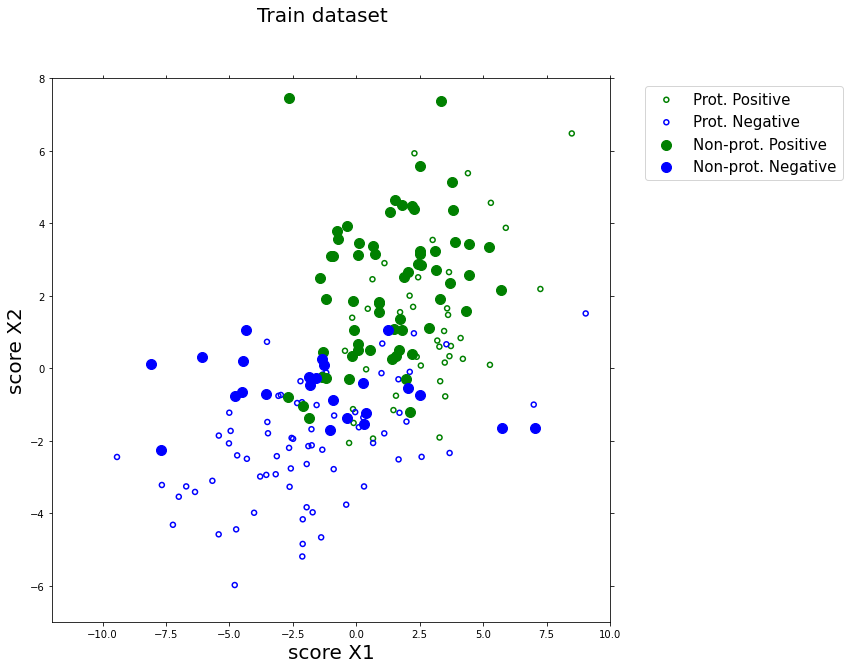

In [2]:
# Plotting training and test data
train_data, X_train, y_train = data.generate_synthetic_data(1000, True) #1000 training samples
data.plot_data(X_train[:,0:2], y_train, X_train[:,2], name='Train')
test_data, X_test, y_test= data.generate_synthetic_data(500, True) # 500 test samples
# plot_data(X_test[:,0:2], y_test, X_test[:,2], name='test')


It can be seen that class labels (green and blue) are highly correlated with the sensitive feature value (protected and non-protected), that is, most of the green (positive class) points are in the non-protected class while most of blue (negative class) points are in the protected class. 

## What Next?

Throughout this notebook we will be analyzing with different fairness metrics by computing the test error of the classifier(s), computing different fairness metrics, outputting the confusion matrix and plotting the classification boundary. 


## Fairness Notions



<img src="images/groups_VS_indi.png" width="500" height="800" />

## Fairness Metrics
We  now take a look at some common group fairness metrics: *demographic parity* and *equal opportunity*, which is a weaker version of *equalized odds*. Note, for simplicity, we assume throughout binary targets $Y$, $\hat{Y}$ and protected attributes $Z$. 


### Demographic parity
*Demographic parity* ([Dwork et al. (2011)](https://dl.acm.org/doi/pdf/10.1145/2090236.2090255)): A binary predictor $\hat{Y}$ satisfies demographic parity  with respect to $Z$ if $$\operatorname{Pr}\{\widehat{Y}=1 \mid Z=0\}=\operatorname{Pr}\{\widehat{Y}=1 \mid Z=1\}.$$ 

-  Define a function `demographic_parity`, that helps to compute *demographic parity* in the binary case. The function should compute $\operatorname{Pr}\{\widehat{Y}=1 \mid Z=z\}$, given predictions $\widehat{Y}$ for group $z$. 

In [3]:
  
def demographic_parity(y_pred, mask): 
    # mask allows to select members of one group (1 if from group, 0 if not)
    if isinstance(mask, np.ndarray): 
        mask = torch.tensor(mask)
    y_cond = y_pred * mask.float()  # conditioned elements
    return y_cond.sum() / mask.sum() # accepted people of group a / total people in group a



### Equal Opportunity
*Equalized Odds* ([Hardt et al. (2016)](https://arxiv.org/pdf/1610.02413.pdf)): A binary predictor $\widehat{Y}$ satisfies equalized odds with respect to protected attribute $Z$ and outcome $Y$, if $\widehat{Y}$ and $Z$ are independent conditional on $Y$. This can be expressed as:

$$ \begin{equation}
\operatorname{Pr}\{\widehat{Y}=1 \mid Z=0, Y=y\}=\operatorname{Pr}\{\widehat{Y}=1 \mid Z=1, Y=y\}, \quad y \in\{0,1\}
\end{equation}$$


*Equal Opportunity* ([Hardt et al. (2016)](https://arxiv.org/pdf/1610.02413.pdf)): A binary predictor $\hat{Y}$ satisfies equal opportunity with respect to $Z$ and $Y$ if $$\operatorname{Pr}\{\widehat{Y}=1 \mid Z=0, Y=1\}=\operatorname{Pr}\{\widehat{Y}=1 \mid Z=1, Y=1\}.$$ 

- Define a function `equal_opportunity`, that helps to compute *equal opportunity* in the binary case. The function should computes $\operatorname{Pr}\{\widehat{Y}=1 \mid Z=z, Y=1\}$, given predictions $\widehat{Y}$, for a ground truth label $y$ and group $z$. 

In [4]:

def equal_opportunity(y_pred, y, mask):
    # mask allows to select members of one group (1 if from group, 0 if not)
    if isinstance(mask, np.ndarray):
        mask = torch.tensor(mask)
    y_cond = y * y_pred * mask.float()  # conditioned true positives
    return y_cond.sum() / (y * mask.float()).sum() # accepted people of group a that have y=1 / total people in group a that have y=1


In [5]:
   
tensor = lambda x: torch.tensor(x.to_numpy())
def get_statistics(model, X_test, y_test, pred, mask, confusion=True):
    print("Test error: ", fairmetric.test_error(pred,y_test))
    if confusion == True:
        print("Confusion matrix all: ")
        print(fairmetric.confusion_matrix(pred,y_test).draw())
        print("Confusion matrix unprotected: ")
        print(fairmetric.confusion_matrix(pred,y_test,mask).draw())
        print(fairmetric.confusion_matrix(pred,y_test,mask).draw())
        print("Confusion matrix protected: ")
        print(fairmetric.confusion_matrix(pred,y_test,1-mask).draw())
    pred = torch.tensor(pred)
    y_test = torch.tensor(y_test)
    print("Positive Rate for unprotected: %.3f, for Positive Rate for protected: %.3f, demographic disparity difference: %.3f" % (demographic_parity(pred, mask),demographic_parity(pred,1-mask), np.abs(demographic_parity(pred, mask)-demographic_parity(pred,1-mask))))
    print("Equal opportunity for unprotected: %.3f, Equal opportunity for protected: %.3f, difference: %.3f" % (equal_opportunity(pred, y_test,mask),equal_opportunity(pred, y_test,1-mask), np.abs(equal_opportunity(pred, y_test,mask) - equal_opportunity(pred, y_test,1-mask))))


# 1. Plain classifier
We start with looking how a LR separates the given biased dataset.
- Train a logistic regression (LR) classifier on the full dataset. You can use a standard implementation from [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), respectively. Evaluate test error, fairness metrics and the confusion matrix for:

i) all samples

ii) only samples of unprotected group 

iii) only samples of protected group.

iv) Plot the decision boundary. 

What do you observe?

In [6]:
# select plain dataset training and test
_X_train = train_data[["x1","x2","sensitive"]].to_numpy()
_y_train = train_data["y"].to_numpy()
_X_test = test_data[["x1","x2","sensitive"]].to_numpy()
_y_test = test_data["y"].to_numpy()
s_test = test_data["sensitive"].to_numpy()

In [7]:
# define and train Logistic Regression classifier
lr_plain = LogisticRegression()
lr_plain.fit(_X_train,_y_train)

# get predictions 
y_pred = lr_plain.predict(_X_test)

# get statistics
get_statistics(lr_plain, _X_test, (_y_test+1)/2, (y_pred+1)/2, s_test)



Test error:  0.131
Confusion matrix all: 
+-----------+----------+----------+---------+
| Real/Pred | Positive | Negative |         |
+===========+==========+==========+=========+
| Positive  | 43.10%   | 6.90%    | 50.00%  |
+-----------+----------+----------+---------+
| Negative  | 6.20%    | 43.80%   | 50.00%  |
+-----------+----------+----------+---------+
|           | 49.30%   | 50.70%   | 100.00% |
+-----------+----------+----------+---------+
Confusion matrix unprotected: 
+-----------+----------+----------+---------+
| Real/Pred | Positive | Negative |         |
+===========+==========+==========+=========+
| Positive  | 69.11%   | 4.81%    | 73.91%  |
+-----------+----------+----------+---------+
| Negative  | 7.09%    | 18.99%   | 26.09%  |
+-----------+----------+----------+---------+
|           | 76.20%   | 23.80%   | 100.00% |
+-----------+----------+----------+---------+
+-----------+----------+----------+---------+
| Real/Pred | Positive | Negative |         |
+======

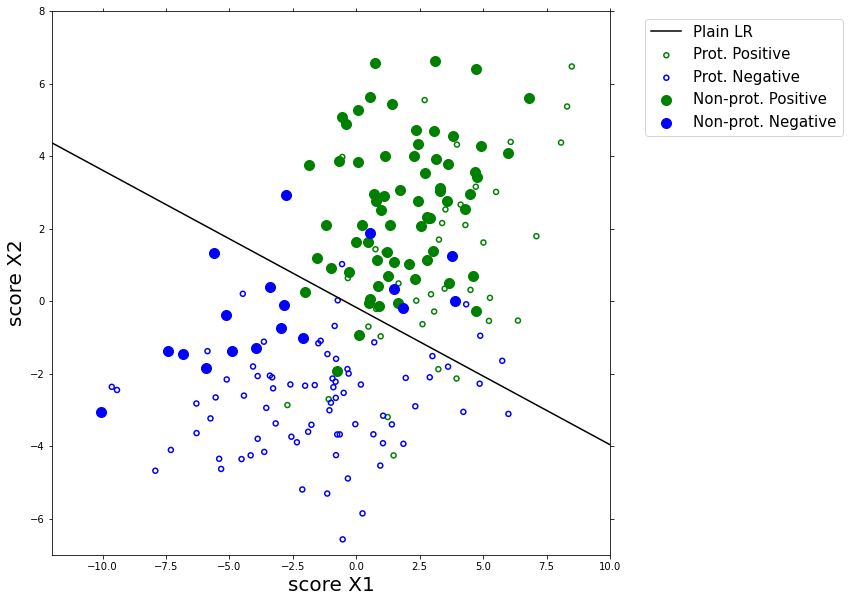

In [8]:
# plot data and decision boundary
fig,ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(*fairmetric.get_lr_boundary(lr_plain.coef_[0][0:2], lr_plain.intercept_, -15,10), color="black", label= "Plain LR")
data.plot_data(X_test[:,0:2], y_test, s_test, ax=ax)

# 2. Unaware classifier
Can't we just train a fair classifier by removing the sensitive attribute from our dataset? 
- Modify the dataset such that contains only non-sensitive features. Train both the SVM and LR classifier on it.  Evaluate test error, fairness metrics and the confusion matrix for:

i) all samples

ii) only samples of unprotected group

iii) only samples of protected group

iv) Plot the decision boundary. What do you observe? 

In [9]:
# select plain dataset trainig and test
_X_train = train_data[["x1","x2"]].to_numpy()
_y_train = train_data["y"].to_numpy()
_X_test = test_data[["x1","x2"]].to_numpy()
_y_test = test_data["y"].to_numpy()
s_test = test_data["sensitive"].to_numpy()

In [10]:
# define and train Logistic Regression classifier
lr_una = LogisticRegression()
lr_una.fit(_X_train,_y_train)

# get predictions 
y_pred = lr_una.predict(_X_test)

# get statistics
get_statistics(lr_una, _X_test, (_y_test+1)/2, (y_pred+1)/2, s_test)

Test error:  0.125
Confusion matrix all: 
+-----------+----------+----------+---------+
| Real/Pred | Positive | Negative |         |
+===========+==========+==========+=========+
| Positive  | 43.30%   | 6.70%    | 50.00%  |
+-----------+----------+----------+---------+
| Negative  | 5.80%    | 44.20%   | 50.00%  |
+-----------+----------+----------+---------+
|           | 49.10%   | 50.90%   | 100.00% |
+-----------+----------+----------+---------+
Confusion matrix unprotected: 
+-----------+----------+----------+---------+
| Real/Pred | Positive | Negative |         |
+===========+==========+==========+=========+
| Positive  | 69.57%   | 4.35%    | 73.91%  |
+-----------+----------+----------+---------+
| Negative  | 7.09%    | 18.99%   | 26.09%  |
+-----------+----------+----------+---------+
|           | 76.66%   | 23.34%   | 100.00% |
+-----------+----------+----------+---------+
+-----------+----------+----------+---------+
| Real/Pred | Positive | Negative |         |
+======

We observe that the fairness metrics only changed a tiny bit -  this is highly dependent on the dataset.

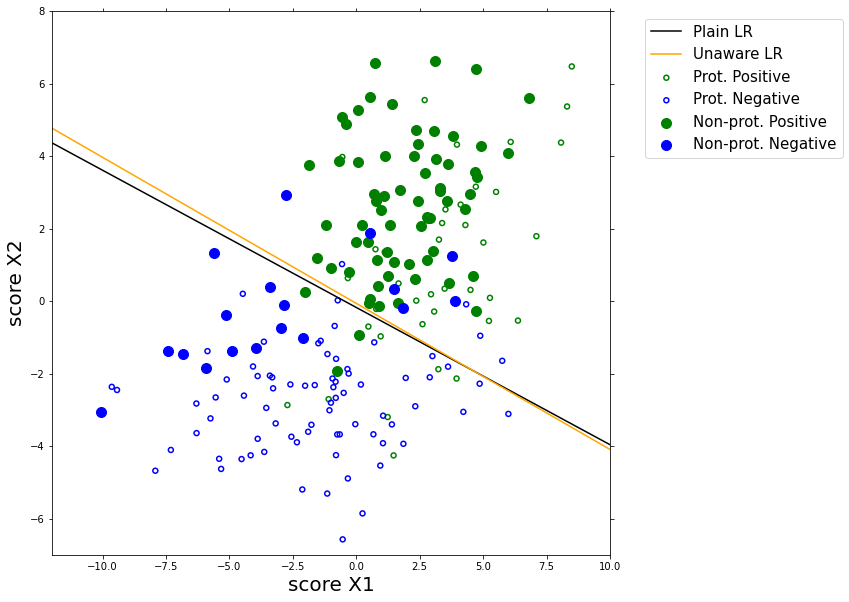

In [11]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(*fairmetric.get_lr_boundary(lr_plain.coef_[0][0:2], lr_plain.intercept_, -15,10), color="black", label= "Plain LR")
ax.plot(*fairmetric.get_lr_boundary(lr_una.coef_[0][0:2], lr_una.intercept_, -15,10), color="orange", label= "Unaware LR")
# ax.plot(*fairmetric.get_lr_boundary(lr_una.coef_[0], lr_una.intercept_, -15,10), color="red", label= "Unaware LR")
data.plot_data(X_test[:,0:2],y_test,s_test,ax=ax)

# Mechanisms to  achieve group fairness

In achieveing fairness, there are three main approaches to achieveing group fairness;

- Pre-preprocessing, which modifies the input data to remove (potential) bias
- Post-processing, which modifies the decisions of a (potentially) unfair classifier
- In-processing, which modifies training to directly learn a fair classifier

<img src="images/methods.png" width="500" height="800" />


Lets now take a closer look at one way of altering the training of a classification algorithm to achieve higher levels of fairness (in-processing).

# 3. In-processing

Let's now take a more detailed look at in-processing approaches for logistic regression e.g. [Zafar et al. (2017)](https://arxiv.org/pdf/1507.05259.pdf). We provide you with the training framework. 

In [12]:
# get training and test datasets as pytorch tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = (torch.tensor(y_train).float()+1)/2
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = (torch.tensor(y_test).float()+1)/2
s_train=X_train_tensor[:,2]
s_test = test_data["sensitive"].to_numpy()

## Plain Classifier

### Binary Cross-Entropy 
Logistic regression typically optimizes the log loss, which is the same as optimizing the (binary) cross-entropy. PyTorch provides a ready-to-use function that measures the [Binary Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html) (BCE) between the target and the output with $N$ samples: 
$$BCE = -\frac{1}{N} \sum_{n=1}^{N}\left[y_{n} \log \hat{y}_{n}+\left(1-y_{n}\right) \log \left(1-\hat{y}_{n}\right)\right]$$

- Lets begin with training a plain LR classifier using the framework. Use binary cross entropy as loss function, which you hand to the training function. Evaluate test error, fairness metrics and the confusion matrix for i) all samples, ii) only samples of unprotected group and iii) only samples of protected group. Plot the decision boundary.

In [33]:
from LR_model import LogisticRegression as Lg # Logistic Regression from scratch not from scikit learn!
# define the model
my_model_plain = Lg(X_train_tensor.size(1))
print(my_model_plain)

LogisticRegression()


In [34]:
import torch.nn as nn

# define the loss function
my_loss_function = nn.functional.binary_cross_entropy  # cross entropy loss
print(my_loss_function)

<function binary_cross_entropy at 0x7fe4523de5e0>


In [36]:

# train the model
# Lg.train(my_model_plain, my_loss_function, X_train_tensor, y_train_tensor, epochs=200, learning_rate=0.05)

In [44]:
# get model predictions
y_pred_plain =  my_model_plain.predict(X_test_tensor)
# get statistics
get_statistics(my_model_plain, X_test_tensor, y_test_tensor, y_pred_plain, s_test, confusion=False)

Test error:  0.146
Positive Rate for unprotected: 0.746, for Positive Rate for protected: 0.341, demographic disparity difference: 0.405
Equal opportunity for unprotected: 0.920, Equal opportunity for protected: 0.785, difference: 0.134


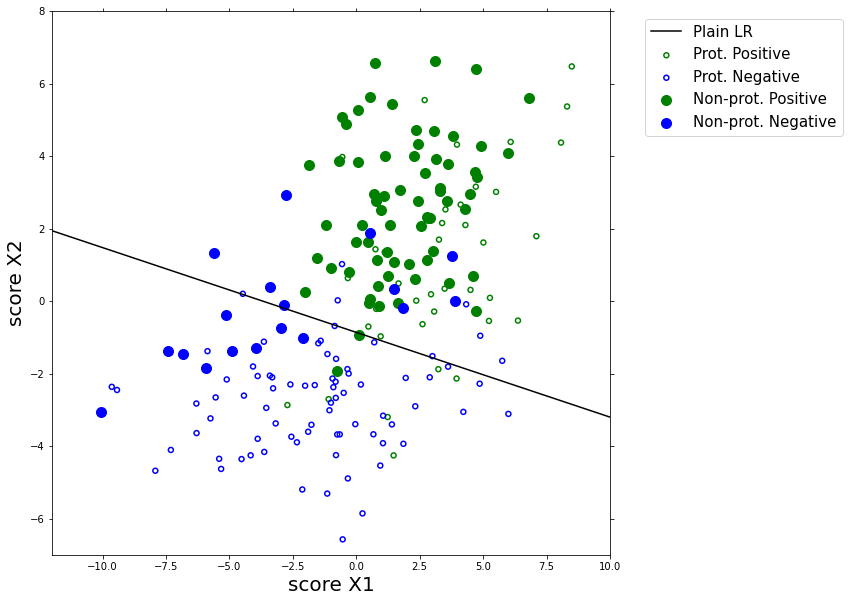

In [48]:
# plot decision boundary
fig,ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(*fairmetric.get_lr_boundary(my_model_plain.theta.detach().numpy()[0:2], my_model_plain.bias.detach().numpy()[0], -15,10), color="black", label= "Plain LR")
data.plot_data(X_test[:,0:2],y_test,X_test[:,2],ax=ax)

## Fair Classifier - Demographic Parity
We can formulate the Demographic Parity (DP) fairness constraints in a Lagrange with multiplier $\lambda$:  
$$DP-Loss = BCE + \lambda * (\mathbb{E}[\widehat{Y}=1 \mid Z=1] - \mathbb{E}[\widehat{Y}=1 \mid Z=0])^2$$
- Train the LR classifier with the fairness metric `demographic_parity`.  This is a constrained optimization problem and you can use an lagrange approach , i.e. `bce_loss + lambda * (unfairness)^2`. Alter the loss function in a suitable way. Then train and evaluate. You can use $\lambda = 100$. What do you observe?

In all cases: 

In [49]:
# define demographic parity loss

def dp_loss(y_pred, y, X_sens, lambda_ = 100.0):
    bce_loss = nn.functional.binary_cross_entropy(y_pred, y) # binary cross entropy 
    sp_unprotected = demographic_parity(y_pred, X_sens)
    sp_protected = demographic_parity(y_pred, 1-X_sens)
    return bce_loss + lambda_ * (sp_unprotected - sp_protected)**2 

In [50]:
# define model
my_model_sp = Lg(X_train_tensor.size(1))
# define loss function 
my_loss_function = dp_loss

# train model
train(my_model_sp, my_loss_function, X_train_tensor, y_train_tensor, X_sens=s_train, epochs=2000, learning_rate=0.05)

Epoch 1: loss 1.8283066749572754
Epoch 500: loss 0.7065107226371765
Epoch 1000: loss 0.6353697776794434
Epoch 1500: loss 0.5752463936805725
Epoch 2000: loss 0.5348799228668213


In [51]:
# get predictions
y_pred_sp  = my_model_sp.predict(X_test_tensor)
# get statistivs
get_statistics(my_model_sp, X_test_tensor, y_test_tensor,y_pred_sp ,s_test, confusion=False)

Test error:  0.199
Positive Rate for unprotected: 0.561, for Positive Rate for protected: 0.440, demographic disparity difference: 0.120
Equal opportunity for unprotected: 0.734, Equal opportunity for protected: 0.904, difference: 0.170


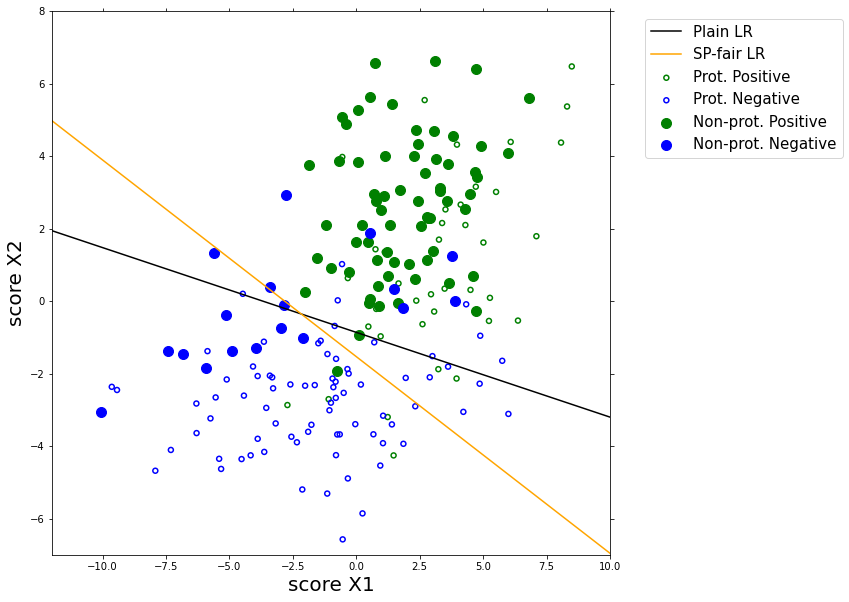

In [53]:
# plot
fig,ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(*fairmetric.get_lr_boundary(my_model_plain.theta.detach().numpy()[0:2], my_model_plain.bias.detach().numpy()[0], -15,10), color="black", label= "Plain LR")
ax.plot(*fairmetric.get_lr_boundary(my_model_sp.theta.detach().numpy()[0:2], my_model_sp.bias.detach().numpy()[0], -15,10), color="orange", label= "SP-fair LR")
data.plot_data(X_test[:,0:2],y_test,X_test[:,2],ax=ax)

## Fair Classifier - Equal Opportunity
We can formulate the equal opportunity (EO) fairness constraints in a Lagrange with multiplier $\lambda$:  
$$EO-Loss = BCE + \lambda * (\mathbb{E}[\widehat{Y}=1 \mid Z=1, Y=1] - \mathbb{E}[\widehat{Y}=1 \mid Z=0, Y=1])^2$$
- 5.3)  Train the LR classifier with the fairness metric `equal_opportunity`. This is a constrained optimization problem and you can use an lagrange approach , i.e. `bce_loss + lambda * unfairness`. Alter the loss function in a suitable way. Then train and evaluate. You can use $\lambda = 100$. What do you observe?

In [54]:
# define equal opportunity loss
def eo_loss(y_pred, y, X_sens, lambda_ = 100):
    bce_loss = nn.functional.binary_cross_entropy(y_pred, y)
    
    eo_unprotected = equal_opportunity(y_pred, y, X_sens)
    eo_protected = equal_opportunity(y_pred,y, 1-X_sens)
    
    return bce_loss + lambda_ * (eo_unprotected - eo_protected)**2 

In [55]:
# define model
my_model_eo = Lg(X_train_tensor.size(1))

# define loss function
my_loss_function = eo_loss

# train model
train(my_model_eo, my_loss_function, X_train_tensor, y_train_tensor,  X_sens=s_train, epochs=2000, learning_rate=0.05)

Epoch 1: loss 4.498537063598633
Epoch 500: loss 0.3386336863040924
Epoch 1000: loss 0.31930091977119446
Epoch 1500: loss 0.31327566504478455
Epoch 2000: loss 0.3111582398414612


In [56]:
# get prediction
y_pred_eo = my_model_eo.predict(X_test_tensor)
# get statistics
get_statistics(my_model_eo, X_test_tensor, y_test_tensor, y_pred_eo, s_test, confusion=False)

Test error:  0.15
Positive Rate for unprotected: 0.675, for Positive Rate for protected: 0.364, demographic disparity difference: 0.311
Equal opportunity for unprotected: 0.867, Equal opportunity for protected: 0.819, difference: 0.048


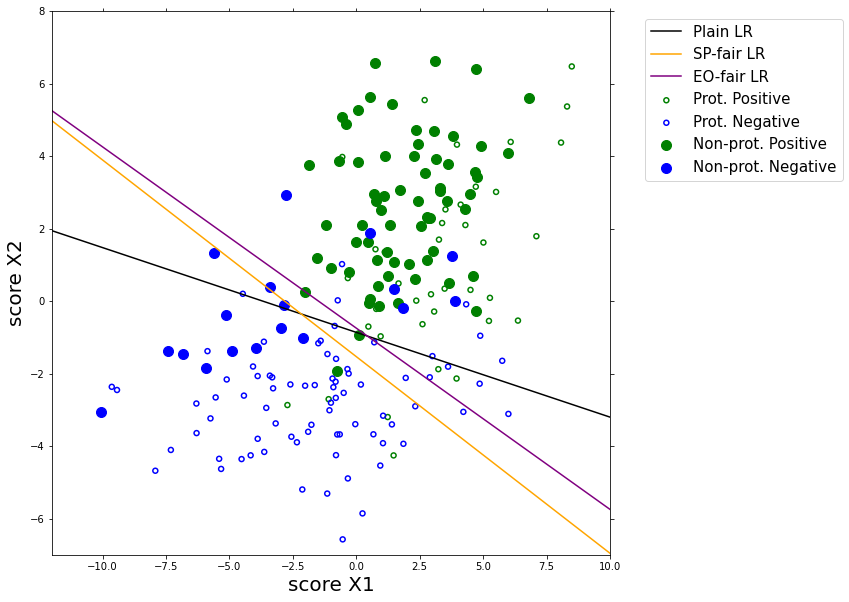

In [57]:
# plot
fig,ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(*fairmetric.get_lr_boundary(my_model_plain.theta.detach().numpy()[0:2], my_model_plain.bias.detach().numpy()[0], -15,10), color="black", label= "Plain LR")
ax.plot(*fairmetric.get_lr_boundary(my_model_sp.theta.detach().numpy()[0:2], my_model_sp.bias.detach().numpy()[0], -15,10), color="orange", label= "SP-fair LR")
ax.plot(*fairmetric.get_lr_boundary(my_model_eo.theta.detach().numpy()[0:2], my_model_eo.bias.detach().numpy()[0], -15,10), color="purple", label= "EO-fair LR")
data.plot_data(X_test[:,0:2],y_test,X_test[:,2],ax=ax)

# 6. Fairness-Accuracy Tradeoff

As introduced in the lecture, the *fairness-accuracy-tradeoff* describes that in general, higher fairness yields lower accuracy, because a fairness constraint diverts the objective from accuracy alone to both accuracy and fairness. Let's try to see that with our implementation. While optimizing for accuracy subject to fairness constraints in the Lagrange implementation above, we adjust the weight that the fairness objective has during training with $\lambda$. While optimizing for accuracy subject to fairness constraints, the higher we choose $\lambda$ the more weight the fairness constraint has in the optimization. For a very high $\lambda$ this may result in a perfectly fair classifier but similarily a rather big loss in accuracy. Lets see if we try a range of values of $\lambda$, what kind of accuracy we achieve. 
- 6.1) For $\lambda = [0,0.1,1,10,100,1000, 10000]$ train a fair LR classifier with the fairness constraint `demographic_parity`. Use the provided function `plot_accuracy_fairness` to evaluate accuracy and fairness metrics for the different values of $\lambda$. What do you observe?

In [60]:
from functools import partial
def plot_accuracy_fairness(model, X_test, y_test, pred, mask, verbose=False):
    err = fairmetric.test_error(pred,y_test)
    y_test = torch.tensor(y_test)
    sp_1,sp_0 = (demographic_parity(pred,mask),demographic_parity(pred,1-mask) )
    eo_1,eo_0 = (equal_opportunity(pred, y_test,mask),equal_opportunity(pred, y_test,1-mask))
    if verbose:
        print("Test error: ", err)
        print("Mean prediction: ", torch.Tensor.float(pred).mean().item())
        print("demographic_parity for unprotected: %.3f, for protected: %.3f, difference: %.3f" % (sp_1,sp_0, sp_1-sp_0))
        print("equal_opportunity for unprotected: %.3f, for protected: %.3f, difference: %.3f" % (sp_1,sp_0, sp_1-sp_0))
    return err, sp_1, sp_0, eo_1, eo_0

In [61]:

torch.manual_seed(1)
lambdas = [0,0.1,1,10,100,1000,10000]
err_list, sp_1_list, sp_0_list, eo_1_list, eo_0_list = [],[],[],[],[] 
verbose = False # if True, it will print out results
for lambda_ in lambdas:
    X_train_tensor = torch.tensor(X_train).float()
    y_train_tensor = (torch.tensor(y_train).float()+1)/2
    X_test_tensor = torch.tensor(X_test).float()
    y_test_tensor = (torch.tensor(y_test).float()+1)/2
    
    my_model_sp = Lg(X_train_tensor.size(1))
    my_loss_function = partial(dp_loss, lambda_=lambda_)

    train(my_model_sp, my_loss_function, X_train_tensor, y_train_tensor, X_sens=X_train_tensor[:,2], epochs=2000, learning_rate=0.05, verbose=False)
    if verbose:
        print("Lambda: %.2f" % lambda_)
    err, sp_1, sp_0, eo_1, eo_0 = plot_accuracy_fairness(my_model_sp, X_test_tensor, y_test_tensor, my_model_sp.predict(X_test_tensor),test_data["sensitive"].to_numpy(), verbose)
    err_list.append(err)
    sp_1_list.append(sp_1)
    sp_0_list.append(sp_0)
    eo_1_list.append(eo_1)
    eo_0_list.append(eo_0)
    if verbose:
        print()
  

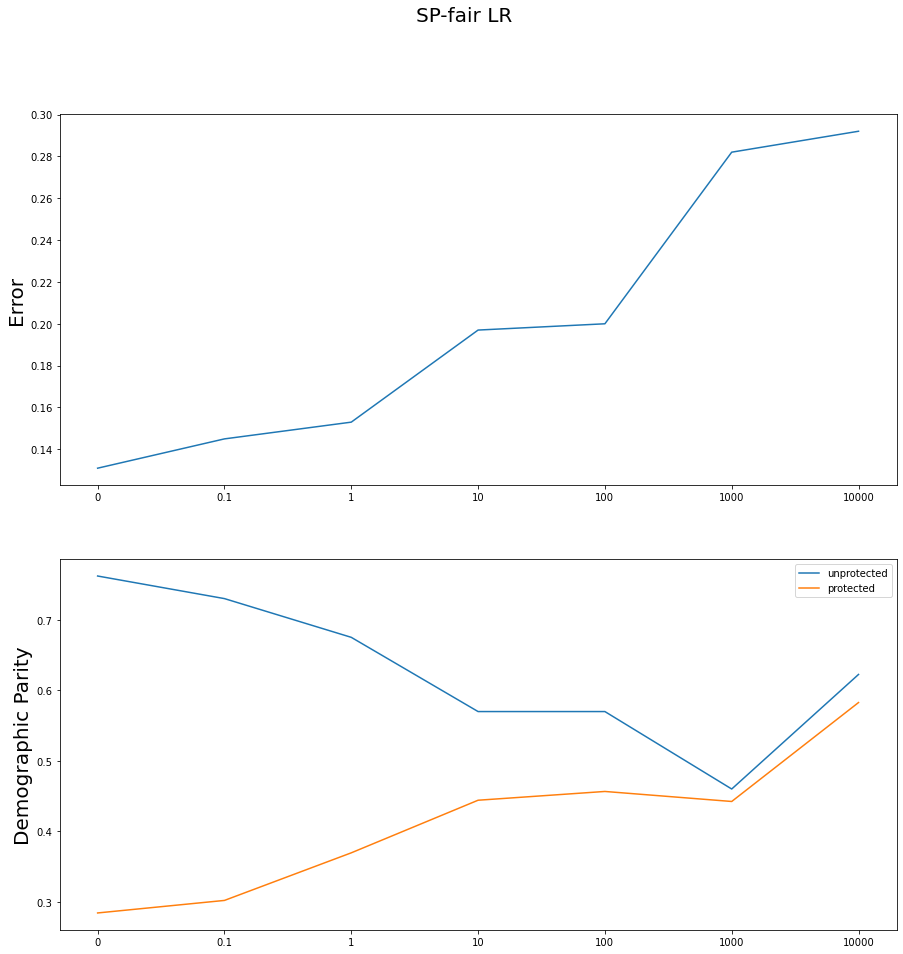

In [64]:
fig, axes = plt.subplots(2,1, figsize=(15,15))
fig.suptitle("SP-fair LR" , fontsize=20)
axes[0].plot(err_list)
axes[0].set_xticks(range(len(lambdas)))
axes[0].set_xticklabels(lambdas)
axes[0].set_ylabel("Error", fontsize=20)
# axes[0].set_xlabel("Lambda", fontsize=20)

axes[1].plot(sp_1_list, label="unprotected")
axes[1].plot(sp_0_list, label="protected")
axes[1].set_xticks(range(len(lambdas)))
axes[1].set_xticklabels(lambdas)
axes[1].set_ylabel("Demographic Parity", fontsize=20)
# axes[1].set_xlabel("Lambda")
axes[1].legend()

# axes[2].plot(eo_1_list, label="unprotected")
# axes[2].plot(eo_0_list, label="protected")
# axes[2].set_xticks(range(len(lambdas)))
# axes[2].set_xticklabels(lambdas)
# axes[2].set_ylabel("Equal Opportunity", fontsize=20)
# axes[2].set_xlabel("Lambda", fontsize=20)
# axes[2].legend()

- 6.2) For $\lambda = [0.01, 0.1, 0, 1, 10, 100, 1000]$ train a fair LR classifier with the fairness constraint `equal_opportunity`. Use the provided function `plot_accuracy_fairness` to evaluate accuracy and fairness metrics for the different values of $\lambda$. What do you observe? 

In [65]:
torch.manual_seed(0)
lambdas = [0,1,10,100,1000, 2000, 4000, 5000]
err_list, sp_1_list, sp_0_list, eo_1_list, eo_0_list = [],[],[],[],[] 
verbose = False # if true, it will print out results
for lambda_ in lambdas:
    X_train_tensor = torch.tensor(X_train).float()
    y_train_tensor = (torch.tensor(y_train).float()+1)/2
    X_test_tensor = torch.tensor(X_test).float()
    y_test_tensor = (torch.tensor(y_test).float()+1)/2
    
    my_model_eo = Lg(X_train_tensor.size(1))
    my_loss_function = partial(eo_loss, lambda_=lambda_)

    train(my_model_eo, my_loss_function, X_train_tensor, y_train_tensor, X_sens=X_train_tensor[:,2], epochs=2000, learning_rate=0.05, verbose=False)
    if verbose: 
        print("Lambda: %.2f" % lambda_)
    err, sp_1, sp_0, eo_1, eo_0 = plot_accuracy_fairness(my_model_eo, X_test_tensor, y_test_tensor, my_model_eo.predict(X_test_tensor),test_data["sensitive"].to_numpy(), verbose)
    err_list.append(err)
    sp_1_list.append(sp_1)
    sp_0_list.append(sp_0)
    eo_1_list.append(eo_1)
    eo_0_list.append(eo_0)
    if verbose: 
        print()

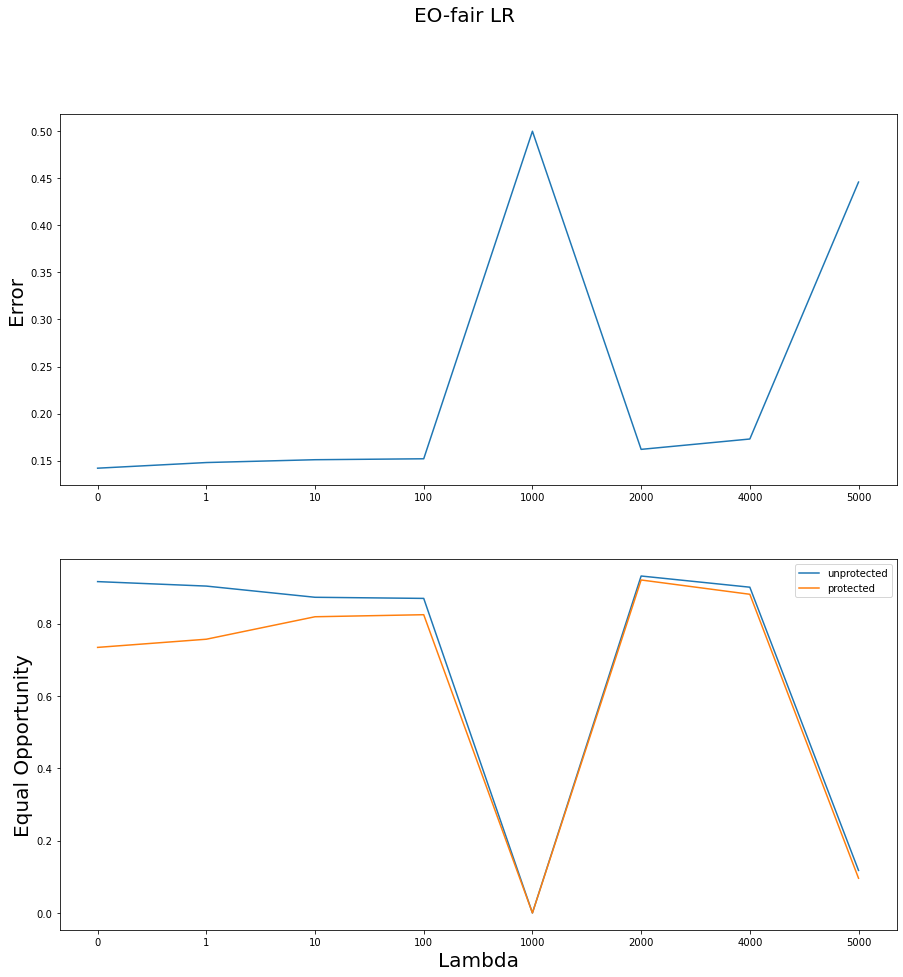

In [66]:
fig, axes = plt.subplots(2,1, figsize=(15,15))
fig.suptitle("EO-fair LR" , fontsize=20)
axes[0].plot(err_list)
axes[0].set_xticks(range(len(lambdas)))
axes[0].set_xticklabels(lambdas)
axes[0].set_ylabel("Error", fontsize=20)
# axes[0].set_xlabel("Lambda", fontsize=20)

# axes[1].plot(sp_1_list, label="unprotected")
# axes[1].plot(sp_0_list, label="protected")
# axes[1].set_xticks(range(len(lambdas)))
# axes[1].set_xticklabels(lambdas)
# axes[1].set_ylabel("Demographic Parity", fontsize=20)
# # axes[1].set_xlabel("Lambda")
# axes[1].legend()

axes[1].plot(eo_1_list, label="unprotected")
axes[1].plot(eo_0_list, label="protected")
axes[1].set_xticks(range(len(lambdas)))
axes[1].set_xticklabels(lambdas)
axes[1].set_ylabel("Equal Opportunity", fontsize=20)
axes[1].set_xlabel("Lambda", fontsize=20)
axes[1].legend()

# 7. Summary / Key Take Away


- Generated synthetic data

    - Trained a plain LR classifier
    
    - Evaluated performance of LR classifier
    
    - Trained a fair classifier using the lagragian approach 
        * $loss + \lambda \times fairness$
        
    - Evaluated fairness using demographic parity and equality of opportunity
    
    - Fairness - Accuracy tradeoffs
    
   
   
- Explore evaluating fairness on real life data - COMPASS
    
    
- Unaware classifer == Fair Classifier

- Impossible to satisfy all fairness constraints at the same time 

**Reminder: While developing and deploying accurate ML models, do not forget to ensure fairness !**



# 8. Further Reading

Ethical machine learning, especially fairness in machine learning, has enjoyed increasing attention in the last years. Here is a non-exhaustive list of links for exploration, if you are interested in more information: 
- Less-technical: Orwat (2019): Risks of Discrimination through the Use of Algorithms, published by the German Federal Anti-Discrimination Agency. Available in [German](https://www.antidiskriminierungsstelle.de/SharedDocs/Downloads/DE/publikationen/Expertisen/studie_diskriminierungsrisiken_durch_verwendung_von_algorithmen.pdf?__blob=publicationFile&v=6) and [English](https://www.antidiskriminierungsstelle.de/SharedDocs/Downloads/EN/publikationen/Studie_en_Diskriminierungsrisiken_durch_Verwendung_von_Algorithmen.pdf?__blob=publicationFile&v=4).
- Technical: Barocas et al. (2019): Fairness and Machine Learning, [here](https://fairmlbook.org/) - a comprehensive technical overview of basic fairness approaches and concepts. Contains also links to further tutorials and lecture material.
- Advanced: Publications at ACM FAccT Conference [here](https://facctconference.org/) - recent cross-disciplinary scientific advances in the research community concerned with fairness, accountability, and transparency in socio-technical systems.
